# Exploratory Data Analysis and Unsupervised Learning in Financial Markets

## Introduction
In exploratory data analysis, you take a dataset, in our case stock prices, and seek to summarize and visualize some characteristics. Classic tools used for this are summary tables, scatterplots, and the like. We'll show you a quick example of how to do that in Python. After, we'll look at grouping the stocks together into clusters, and visualize them better with dimensionality reduction.

### Importing Libraries

In [32]:
#bread and butter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#exotic clustering algorithm, TDA
from tomaster import tomato
import kmapper

#machine learning library
import sklearn

#machine learning library for time series
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

#backtester
import bt

#misc
%matplotlib inline
plt.style.use('matplotlibrc')

## EDA

### Getting Price Data
Here, we get price data for five stocks, and calculate daily returns for them. In a sense, here we "clean" the data and transform it into a form suitable for analysis. Why wouldn't we just use raw price data here? When looking at how stocks are correlated with each other, examining how raw prices are correlated would be somewhat meaningless. Stocks usually go up, and would be correlated in most cases. What we are really interested in is whether stock A tends to rise whenever stock B rises, and so we calculate daily returns.

In [5]:
tech = ['aapl', 'msft', 'goog', 'amzn', 'fb']
tech_prices = bt.get(tech, start='2015-01-01')
tech_returns = tech_prices.pct_change(1).dropna()

### Pairwise Visualizations

With exploratory data analysis, you take a dataset and try to make sense of it with summaries, plots, visualizations, and the like. You should be looking for insights with tools such as scatter plots, boxplots, histograms, pie charts, so on and so forth. Here, we use the trick of creating a grid of visualizations, with scatter plot in the top right triangle, kernel density estimates in the bottom left triangle, and histograms down the diagonal. This is a nice representation of pairwise dependencies in the data that is space-efficient and concise. It's probably a good idea to do this if you ever wanted to pairs trade any of these stocks. 

An interesting observation is that these stocks are all moderately correlated, but the only strongly correlated pair happens to be Microsoft and Google. Tech stocks may not be as correlated as you would think! 

There are many outliers in most of the regressions performed as well. Linear regression is not very robust against outliers, and as such we see that the confidence intervals on some of the regressions are not-insignificant. 

Here's more information on this. https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

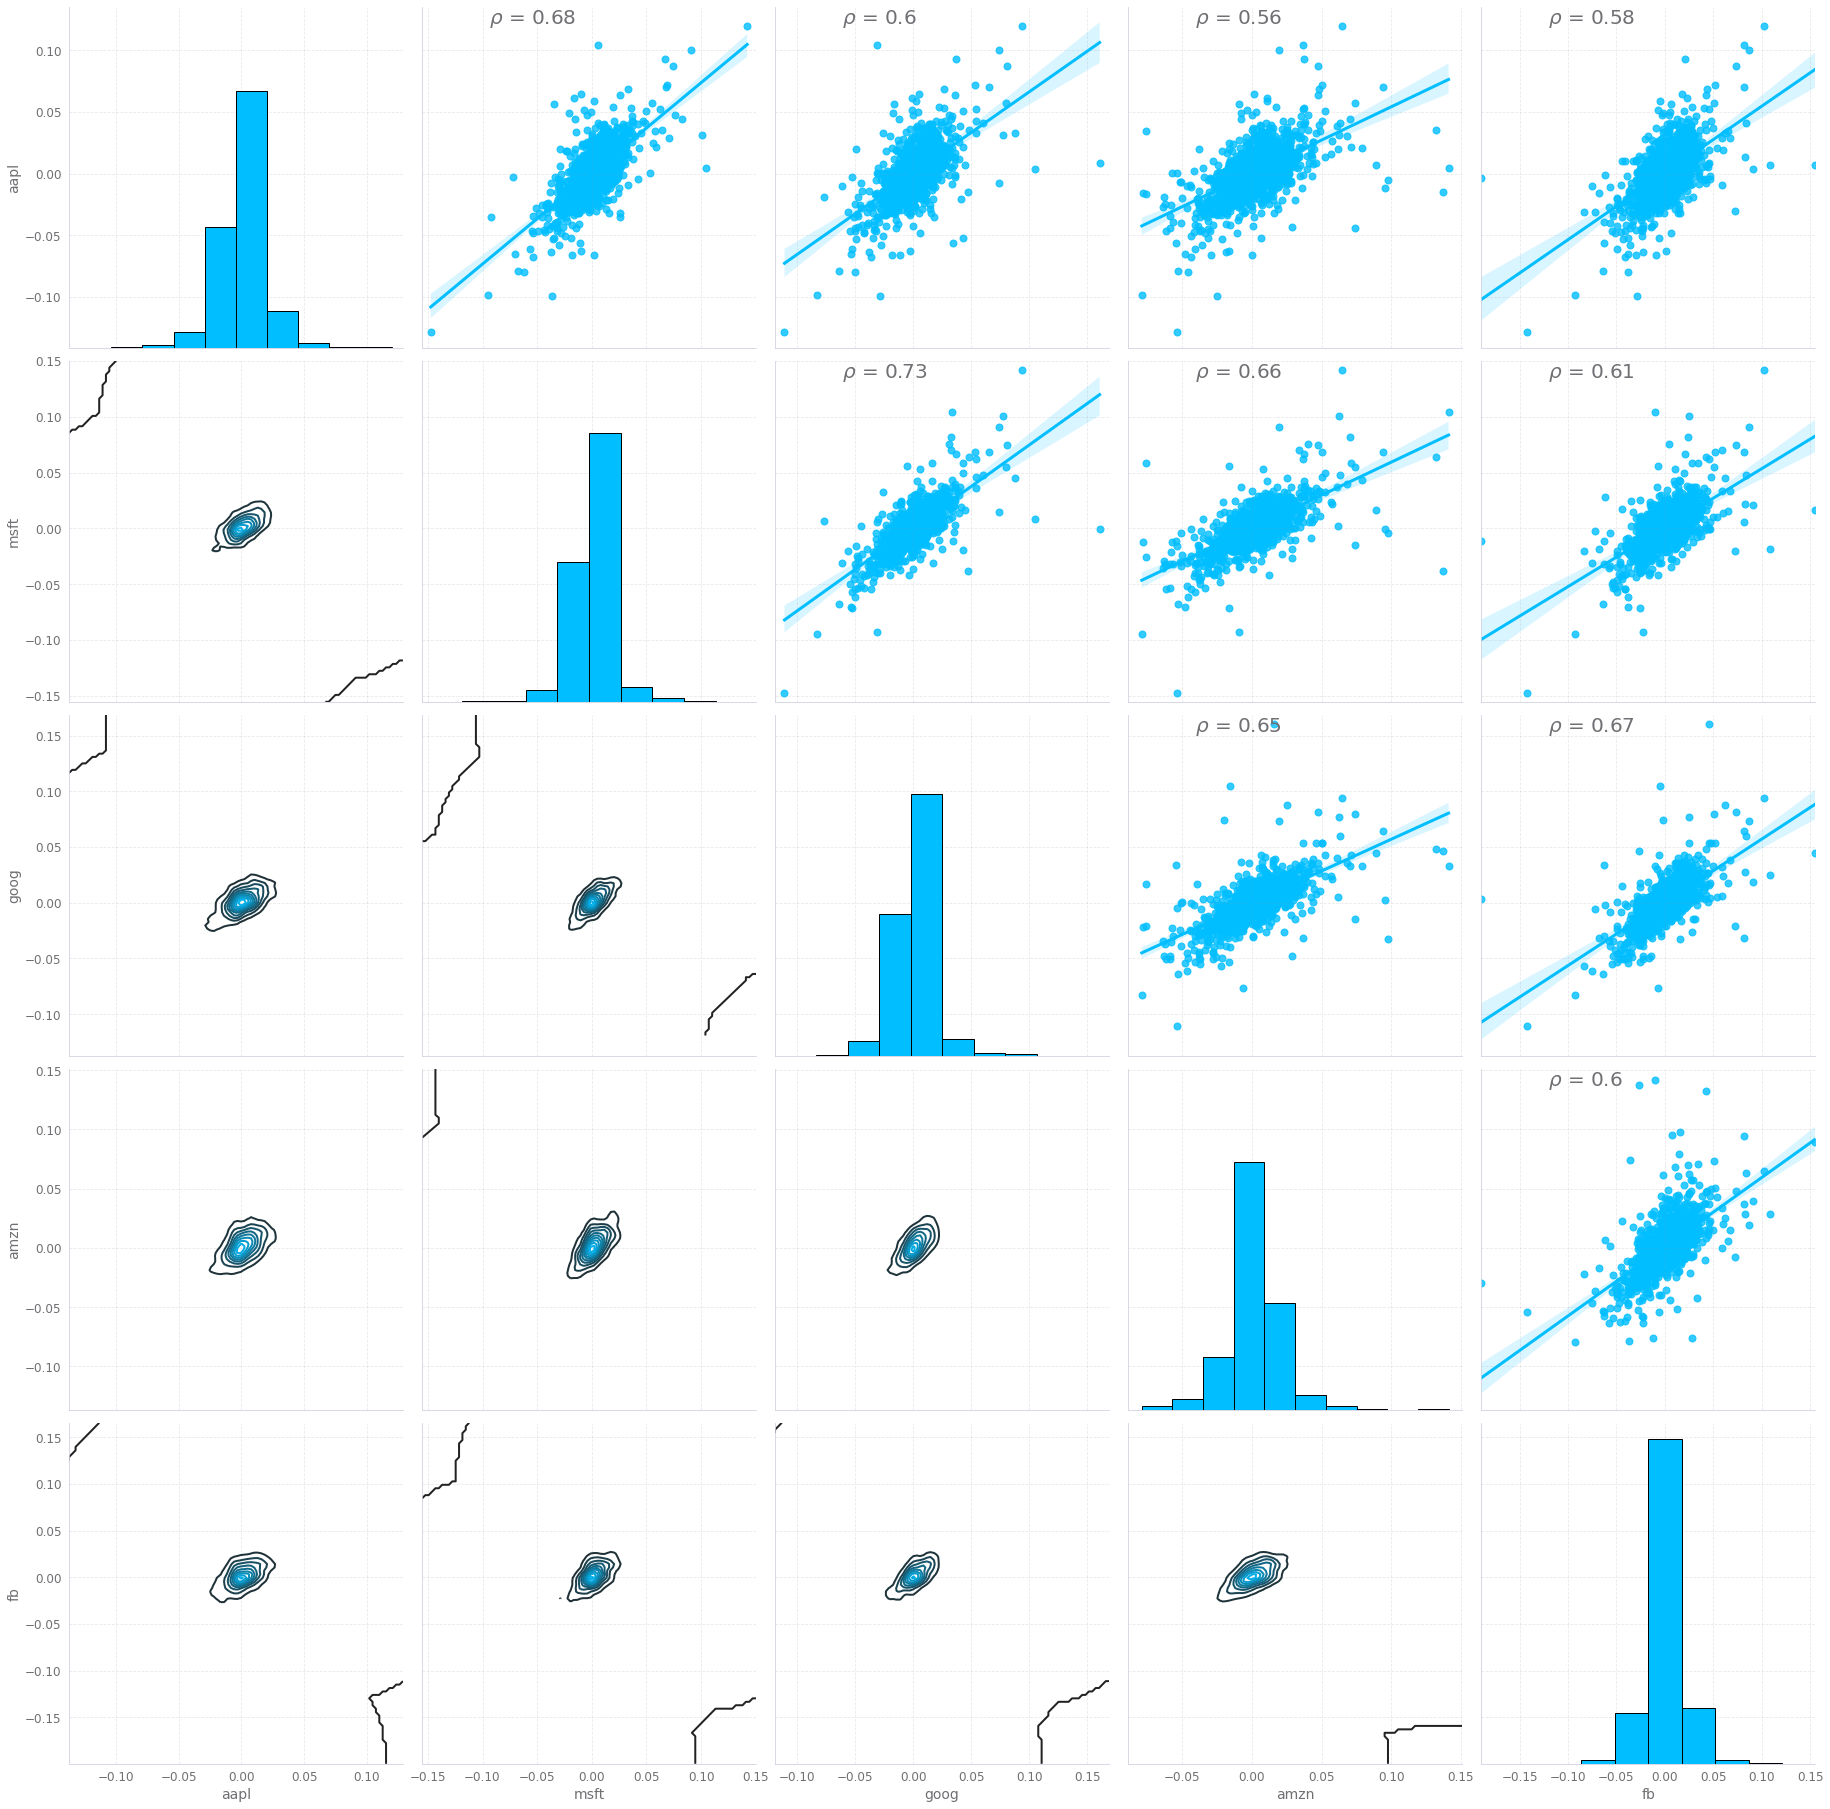

In [6]:
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

grid = sns.PairGrid(data=tech_returns,
                    vars = ['aapl', 'msft', 'goog', 'amzn', 'fb'], height = 5)
grid = grid.map_upper(sns.regplot)
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot)
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k');

### Boxplots

Two visualizations are created here, one with a little bit of jitter on the x-axis to better visualize the density of the data, and the other without (which emphasizes outliers). We can see that the majority of daily returns lie within a well-behaved range, but each stock has some very, very good days and some very, very bad ones. Facebook has had the worst day since 2020 out of all of them, and Apple has had the best. 

Here's how you can do the scattered boxplots. https://towardsdatascience.com/scattered-boxplots-graphing-experimental-results-with-matplotlib-seaborn-and-pandas-81f9fa8a1801

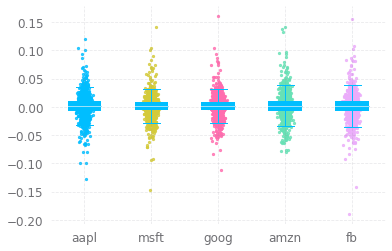

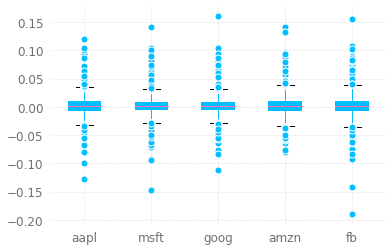

In [30]:
vals, names, xs = [],[],[]
for i, col in enumerate(tech_returns.columns):
    vals.append(tech_returns[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, tech_returns[col].values.shape[0]))
    
plt.boxplot(vals, labels=names, showfliers=False)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.8, s=5)
plt.show()

tech_returns.boxplot()

## Clustering

So far, we've examined what we can do with five assets. But what if you had 50, 500, or 5000? It quickly becomes impractical to visualize each of them. In this case, you can group them into clusters and perform the above analysis on a cluster, or a subset of a cluster, of interest. You can also use these clusters to perform more robust searches for, say, cointegrated pairs in pairs trading.

We look at 3 clustering algorithms here. They are:

1. k-means
2. DBSCAN
3. ToMATo

The first two are more well-established, and approach the problems from perspectives unrelated to persistence. The last uses an approach rooted in persistence and algebraic topology. Briefly, 

| Algorithm      | Description | Core Idea | Characteristics |
| :----------- | :----------- | :----------- | :----------- |
| k-means      | Create n "centroids" for the data at random. Assign each data point to its closest centroid. Update centroids to be the mean location of the data points assigned to it. Repeat <cite data-cite="8504090/WEUA8VFV"></cite>.       | Assigning data points to clusters based on how close they are to their centers. |  Very simple. Relatively evenly-sized convex (or circular) clusters <cite data-cite="8504090/9ELQVJQ8"></cite>.  Fast, linear-time in practice <cite data-cite="8504090/SMA7VIC8"></cite>. |
| DBSCAN   | For each data point $A$, expand the cluster containing it through assigning all other unclassified points to the cluster if they is within a certain distance $\epsilon$ from it, and there are greater than $minPts$ points within $\epsilon$ from $A$. Recursively, do the same for every point $B$ added to the first-level cluster with $A$, and every data point added to the second-level cluster with $B$, and so on <cite data-cite="8504090/9ELQVJQ8"></cite>.   | Clustering nearby points in areas of high-enough density.  | Clusters of any shape, potentially uneven sizes, suitable for non-Euclidean geometry <cite data-cite="8504090/9ELQVJQ8"></cite>. Points in areas of low density classified as noise (potentially wrongly). Speed concerns, log-linear average-case <cite data-cite="8504090/JFXN32WV"></cite>, quadratic worse-case <cite data-cite="8504090/5Y9E5QRY"></cite>.   
| ToMATo | Estimate the density of the data, find the most persistent/prominent density peaks and make each a "head" of a cluster, merge significantly less-prominent peaks into the clusters of the most prominent ones <cite data-cite="undefined"></cite>.  |  Merge clusters/points of less prominence into those of more prominence. | Clusters of any shape and size, flexible, generic, suitable for non-Euclidean geometry. Responds well to hierarchical datasets, unlike DBSCAN. Fast, almost-linear time in the worst case <cite data-cite="undefined"></cite>. |

We'll use DBSCAN first, them ToMATo, and finally a variant of k-means. First, we import stock data for the top 50 stocks in the S&P500 (barring Berkshire Hathaway, for convenience).

In [36]:
top50 = 'AAPL, MSFT, AMZN, FB, GOOGL, GOOG, TSLA, JPM, JNJ, NVDA, V, PYPL, DIS, PG, UNH, HD, MA, BAC, INTC, NFLX, CMCSA, VZ, ADBE, CRM, ABT, XOM, T, WMT, TMO, CSCO, AVGO, PFE, KO, MRK, ABBV, PEP, CVX, NKE, ACN, LLY, TXN, QCOM, MDT, MCD, NEE, COST, DHR, WFC, UNP'
djia_prices = bt.get(top50, start='2020-01-01')
djia_returns = djia_prices.pct_change(1).dropna()

This is a function to take in an array of positions of a stock in the `top50` array and output the names of each.

In [37]:
def pred2names(y_pred, names):
    clusters = []
    for i in range(max(y_pred) + 1):
        cluster = []
        for j in range(len(names)):
            if y_pred[j] == i:
                cluster.append(names[j])
        clusters.append(cluster)
    return clusters

### DBSCAN

DBSCAN (and its variants and offshoots) is a classical algorithm that, according to Akbar and Khan in their survey of existing literature, titled "Critical Analysis of Density-based Spatial Clustering of Applications with Noise (DBSCAN) Techniques,", deals very well with non-convex shaped data, and uneven cluster sizes <cite data-cite="8504090/5Y9E5QRY"></cite>. 

The three main shortcomings that Akbar and Khan highlight are:

1. DBSCAN's $O(n^2)$ worst-case time complexity
2. DBSCAN's inability to deal with clusters of different densities
3. The difficulty in setting the algorithm's input parameters

A corollary of a shortcoming of DBSCAN (specifically, the second) mentioned by Akbar and Khan manifests in its tendency to disregard points in locations with low density as noise. 

As we can see here, results are reasonable, except for one issue. Bear in mind that the first cluster is what DBSCAN calls noise -- which is unacceptable. `AMZN` and `FB` are hardly outliers, after all.

In [38]:
dbscan_pred = sklearn.cluster.DBSCAN(eps=0.3, min_samples=2).fit(djia_returns.T)
dbscan_pred.labels_+1
pred2names(dbscan_pred.labels_+1, djia_returns.columns)

[['amzn',
  'fb',
  'tsla',
  'nvda',
  'pypl',
  'dis',
  'unh',
  'intc',
  'nflx',
  'crm',
  'xom',
  'csco',
  'avgo',
  'cvx',
  'nke',
  'lly',
  'txn',
  'qcom',
  'nee'],
 ['aapl', 'msft', 'googl', 'goog', 'adbe'],
 ['jpm', 'bac', 'wfc'],
 ['jnj',
  'pg',
  'hd',
  'cmcsa',
  'vz',
  'abt',
  't',
  'wmt',
  'tmo',
  'pfe',
  'ko',
  'mrk',
  'abbv',
  'pep',
  'cost',
  'dhr'],
 ['v', 'ma', 'acn', 'mdt', 'mcd', 'unp']]

### ToMATo

Chazal et. al. introduce an algorithm that, according to its creators, can deal with clusters of any shape and size (unlike k-means), is flexible and generic, is suitable for non-Euclidean geometry, responds well to varying levels of density in the data and hierarchical datasets (unlike DBSCAN), and very importantly is fast, achieving almost-linear time in the worst case.

Results are very promising. Simply looking at the first five entries of the first cluster says enough (in this run, it was the first five stocks we analyzed earlier except for `AMZN`).

In [44]:
y_pred = tomato(djia_returns.T, k=2, n_clusters=8)
pred2names(y_pred[0], djia_returns.columns)

[['aapl',
  'msft',
  'fb',
  'googl',
  'goog',
  'tsla',
  'nvda',
  'pypl',
  'intc',
  'nflx',
  'adbe',
  'crm',
  'csco',
  'avgo',
  'acn',
  'txn',
  'qcom'],
 ['amzn',
  'jnj',
  'pg',
  'unh',
  'hd',
  'cmcsa',
  'vz',
  'abt',
  't',
  'wmt',
  'tmo',
  'pfe',
  'ko',
  'mrk',
  'abbv',
  'pep',
  'lly',
  'mcd',
  'nee',
  'cost',
  'dhr'],
 ['jpm', 'bac', 'xom', 'cvx', 'wfc'],
 ['v', 'dis', 'ma', 'nke', 'mdt', 'unp']]

### Time Series K Means

There is a subtle issue in the above approaches. So far, we've taken each time series of a stock, dumped it into the algorithm as an "observation" or "data point", and told it to put it into a cluster based on the Euclidean distance between it and the other time series. This is all well and good in most cases in the daily setting, but consider what would happen if we took a time series, shifted it by one day, and compared it with the original one. It would have a very, very large error that is completely unrepresentative of reality. As such, one needs to take into account temporal differences in the data. This isn't so much of an issue in daily data, but if you had a high-frequency trading model that trades every millisecond, and dependencies between stocks lag by just five milliseconds, that'd mean five "off" trades! One metric that helps with this is `dtw`, or Dynamic Time Warping, as opposed to standard Euclidean distance.

We perform time series k-means, and find that results are reasonable. 

The link here provides more information. https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3

In [40]:
model = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=10)
pred2names(model.fit_predict(djia_returns), djia_returns.columns)

[['msft',
  'fb',
  'tsla',
  'nvda',
  'ma',
  'intc',
  'vz',
  'xom',
  'wmt',
  'csco',
  'pfe'],
 ['hd', 'nflx', 'abbv', 'pep', 'nke', 'txn', 'mdt', 'mcd', 'dhr'],
 ['cmcsa'],
 ['nee', 'wfc'],
 ['lly', 'qcom', 'cost', 'unp'],
 ['aapl',
  'amzn',
  'googl',
  'goog',
  'jpm',
  'jnj',
  'v',
  'pypl',
  'dis',
  'pg',
  'unh',
  'bac',
  'adbe',
  'crm',
  'abt',
  't',
  'tmo',
  'avgo',
  'ko',
  'mrk',
  'cvx',
  'acn']]

## Dimensionality Reduction

Clustering lets us make more sense of the data. But it doesn't provide a very "visual" way to analyze it. Here are some approaches in dimensionality reduction that do. But first, consider the problem in our context. We have about a year's worth of stock data. That means roughly 300 entries in each time series for one stock alone. We need to reduce these 300 entries to just two or three -- so we can plot them on the plane or in the cube, and visualize them in Euclidean space. Here are some approaches to do that.

But why does this work? This brings into mind the Manifold Hypothesis, that high-dimensional data really lies in low-dimensional "generalizations of surfaces" called manifolds, which need not be linear and can have shapes as unintuitive as the Klein bottle. If data does lie on a low-dimensional manifold, then it is very possible that we could just "fit" the data onto this manifold, if we can find it, and there we have dimensionality reduction with little-to-no information loss! In practice, this is difficult, and we have a set of heuristic algorithms to do this. We will discuss two -- PCA and t-SNE. The below link explains the Manifold Hypothesis in further detail.

https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis#:~:text=The%20Manifold%20Hypothesis%20states%20that,within%20the%20high%2Ddimensional%20space.&text=A%20manifold%20is%20really%20just,classify%20spaces%20of%20arbitrary%20dimension.

What do we do here? We apply these algorithms to reduce the dimensionality down to just two dimensions. If stocks are close together on the plane, we assume they are related/similar. We first calculate a distance matrix based on the `dtw` distance metric. This'll be fed into the algorithms later.

In [46]:
distances = np.zeros((len(djia_returns.columns),len(djia_returns.columns)))
for i in range(len(djia_returns.columns)):
    for j in range(len(djia_returns.columns)):
        distances[i, j] = dtw(djia_returns[djia_returns.columns[i]],
                             djia_returns[djia_returns.columns[j]])
distances

array([[0.        , 0.21501024, 0.28621685, ..., 0.28509845, 0.39101951,
        0.31366061],
       [0.21501024, 0.        , 0.25476078, ..., 0.2607354 , 0.3722058 ,
        0.28647771],
       [0.28621685, 0.25476078, 0.        , ..., 0.27004941, 0.41566927,
        0.31197987],
       ...,
       [0.28509845, 0.2607354 , 0.27004941, ..., 0.        , 0.40394107,
        0.27562379],
       [0.39101951, 0.3722058 , 0.41566927, ..., 0.40394107, 0.        ,
        0.35959872],
       [0.31366061, 0.28647771, 0.31197987, ..., 0.27562379, 0.35959872,
        0.        ]])

### PCA

This is a wonderful application of the Spectral Theorem from linear algebra. We find the eigenvectors and eigenvalues of the (symmetric, and hence orthogonally diagonalizable) covariance matrix, and rank them by magnitude of eigenvalues. The largest eigenvalue corresponds to an eigenvector of stock weights in a portfolio that explains the largest variance in the returns, and is the market portfolio. The second-largest eigenvalue (and all others, other than the first) correspond to eigenvectors that are orthogonal to the first, as the eigenvectors are orthogonal, and so should be uncorrelated with the market (if anyone wanted a zero-beta portfolio, here's an easy way). This is great for factor analysis, as we see in the links below.

https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e

https://www.math.nyu.edu/faculty/avellane/Lecture2Quant.pdf

As a dimensionality reduction algorithm, however, it can be lacking. Stock returns need not lie on a linear manifold, but PCA assumes they lie on a linear subspace. We see odd results here. We all knew `TSLA` was an outlier though, and this seems to confirm it.

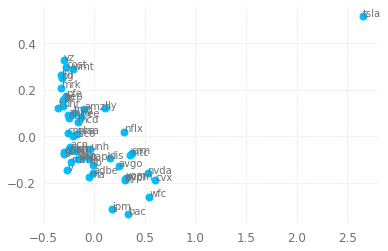

In [49]:
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(distances)
fig, ax = plt.subplots()
ax.scatter(pca[:,0], pca[:, 1])
for i, txt in enumerate(djia_returns.columns):
    ax.annotate(txt, (pca[i, 0], pca[i, 1]))

### t-SNE

t-SNE, or t-distributed stochastic neighbor embedding, tries to compress high dimension data into lower dimensional space, preserving distance and neighborhood structure. Vanilla SNE converts Euclidean distances into similarities, that can be interpreted as probabilities of whether other data points are neighbors of a given data point. In t-SNE, we assume a t-distribution, which provides more robustness to noise and uncertainty. 

Here's an intuitive explanation.
https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a

Here's a summary on the differences.
https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/

And as we can see, our favorite cloud of `AAPL`, `MSFT`, `GOOG`, `DB` are close together, except for `AMZN` yet again -- mimicking the results of ToMATo. 

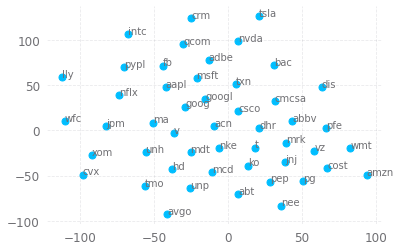

In [50]:
tsne = sklearn.manifold.TSNE(n_components=2, metric="precomputed").fit_transform(distances)
fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:, 1])
for i, txt in enumerate(djia_returns.columns):
    ax.annotate(txt, (tsne[i, 0], tsne[i, 1]))

In [10]:
tsneDF = pd.DataFrame(tsne.T, columns = djia_returns.columns)

### Mapper

Here's a bonus algorithm. It'll give you a HTML file. Open it in a new tab.

Here's an explanation.
https://www.quantmetry.com/blog/topological-data-analysis-with-mapper/

In [29]:
mapper = kmapper.KeplerMapper()
#projected_data = mapper.fit_transform(X=distances, projection=sklearn.manifold.TSNE, scaler=None)
#projected_data = mapper.fit_transform(X=djia_returns.T, projection=[0,1])
graph = mapper.map(tsne, distances, cover=kmapper.Cover(n_cubes=10))
mapper.visualize(graph, X_names = list(djia_returns.columns), path_html="djia_keplermapper_output.html")

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Kepler Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  position: absolute;\n  right: 00px;\n  top: 0px;\n  width: 90px;\n  height: 90px;\n  z-index: 999999;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n 